<div class="alert alert-info">
<font size="4", color = "brown"><b>✍ Комментарий студента v0</b></font>
    <br /> 
    <font size="3", color = "brown">
<br /> Добрый день, уважаемый ревьюир. 
        
Благодарю тебя за время потраченное на мой проект. Буду благодарен за полезные советы и лайфхаки. 
        
Буду очень благодарен за замечания которые позволят этот проект перевести в продукт.
        
Немного исправил Прекод, т.к. при добавлении импортов и т.д. нумерация не отражала действительность. 

# Прекод

# Демонстрационная версия поиска изображений по запросу

**Задача:**

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

## Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## Загрузка данных

In [1]:
# pip install transformers

In [2]:
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [3]:
# pip install pycuda

In [4]:
# База и графики
import os
import re
from PIL import Image
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from tqdm import notebook, tqdm

# Текст
import spacy
import nltk
# from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag


# Нейросети
import torch
import transformers
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torchvision.models import ResNet18_Weights, resnet18
import torchvision.transforms as transforms
from torch.autograd import Variable

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression


C:\YandexDisk\Code\.neural_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Проверка на доступность GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")
print(torch.version.cuda) 

Используемое устройство: cuda
11.8


In [6]:
BASE_PATH = './data/'
TRAIN_IMAGES = os.path.join(BASE_PATH, 'train_images') 
TEST_IMAGES = os.path.join(BASE_PATH, 'test_images') 
RS = 42
LETTERS = r'[^a-zA-Z\s]'
SPACES = r'([ ])\1+'

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\fd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fd\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\fd\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [7]:
files = os.listdir(BASE_PATH)

for file in files:
    print(file)

CrowdAnnotations.tsv
ExpertAnnotations.tsv
test_images
test_images.csv
test_queries.csv
text_features.npy
train_dataset.csv
train_images


In [8]:
# загрузка информации для обучения:
try:
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train_dataset.csv'))
    print('[bold]Информация для обучения:')
    display(train_df.head(2))
    display(train_df.info())
except Exception as e: 
    print('Информация для обучения недоступна:', e) 

# загрузка информации для тестирования:
try:
    test_df = pd.read_csv(os.path.join(BASE_PATH, 'test_queries.csv'), sep='|', index_col='Unnamed: 0')
    print('[bold]Информация для тестирования:')
    display(test_df.head(2))
    display(test_df.info())
except Exception as e: 
    print('Информация недоступна:', e) 


# оценка изображений на краудсорсинге
try:
    crowd_annotat = pd.read_csv(os.path.join(BASE_PATH, 'CrowdAnnotations.tsv'), sep='\t',
                                names=['image', 'query_id', 'fraction', 'conf_cnt', 'not_conf_cnt'])
    print('[bold]Оценка изображений на краудсорсинге:')
    display(crowd_annotat.head(2))
    display(crowd_annotat.info())
except Exception as e: 
    print('Информация недоступна:', e) 


# оценка изображений экспертами
try:
    expert_annotat = pd.read_csv(os.path.join(BASE_PATH, 'ExpertAnnotations.tsv'), sep='\t',
                                names=['image', 'query_id', 'exp_1', 'exp_2', 'exp_3'])
    print('[bold]Оценка изображений экспертами:')
    display(expert_annotat.head(2))
    display(expert_annotat.info())
except Exception as e: 
    print('Информация недоступна:', e) 

[bold]Информация для обучения:


,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


None

[bold]Информация для тестирования:


,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg


<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


None

[bold]Оценка изображений на краудсорсинге:


,image,query_id,fraction,conf_cnt,not_conf_cnt
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         47830 non-null  object 
 1   query_id      47830 non-null  object 
 2   fraction      47830 non-null  float64
 3   conf_cnt      47830 non-null  int64  
 4   not_conf_cnt  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None

[bold]Оценка изображений экспертами:


,image,query_id,exp_1,exp_2,exp_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   exp_1     5822 non-null   int64 
 3   exp_2     5822 non-null   int64 
 4   exp_3     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


None

In [9]:
table = [train_df, test_df, crowd_annotat, expert_annotat]  
print('Посмотрим на пропуски:')
for i in table:
    display(i.isnull().mean().sort_values())
    
    
print('Посмотрим на дубликаты:')
for i in table:    
     display(i.duplicated().sum())

Посмотрим на пропуски:


image         0.0
query_id      0.0
query_text    0.0
dtype: float64

query_id      0.0
query_text    0.0
image         0.0
dtype: float64

image           0.0
query_id        0.0
fraction        0.0
conf_cnt        0.0
not_conf_cnt    0.0
dtype: float64

image       0.0
query_id    0.0
exp_1       0.0
exp_2       0.0
exp_3       0.0
dtype: float64

Посмотрим на дубликаты:


np.int64(0)

np.int64(0)

np.int64(0)

np.int64(0)

## Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [10]:
def e_d_a(variable, name, table):
    print(f'Смотрим статистику: {name}')
    # Статистика
    display(table[variable].describe())

    # Гистограмма
    plt.figure(figsize=(15, 6))
    table[variable].hist(bins=30, range=(max(0, table[variable].min()), table[variable].max()))
    plt.title(f'Распределение {name}')
    plt.xlabel(f'{name}')
    plt.ylabel('Частота')
    plt.show()
    
    # Диаграмма с усами
    plt.figure(figsize=(15, 4))
    table.boxplot(column=variable, vert=False, color='green', widths=0.6)
    plt.title(f'Диаграмма межквартильного размаха для {name}')
    plt.xlabel(f'{name}')
    plt.yticks([]) 
    plt.grid(True, linestyle='--', alpha=0.2, linewidth=1.5)
    plt.show()


    # Описание границ
    print('\n', f'{name} находится в диапазоне от {table[variable].min():.2f}',
          f'до {table[variable].max():.2f}, посмотрим как распределяются данные, видим на графике выше:'
         )

    # Вывод 75% и 98% квантилей
    print(f'75% объектов находятся в диапазоне до {table[variable].quantile(0.75):.1f}',
          f'\n \n Всего значений отличных от 0: {len(table[table[variable]>0]):.1f}.',
          f'\n 1Q = {table[variable].quantile(0.25):.1f},',
          f'\n 3Q = {table[variable].quantile(0.75):.1f},',
          f'\n Межквартильный размах = {(table[variable].quantile(0.75) - table[variable].quantile(0.25)):.1f},',
         )
    
def e_d_a_categorical(variable, name, table):
    counts = table[variable].value_counts().sort_values(ascending=False)
    print(f'Смотрим статистику: {name}')
    display(table[variable].describe())
    print('Лидеров и аутсайдеров: ')
    display(counts)
    if len(counts)>20:
        print('Посмотрим на графике ТОП-10: ')
        plt.bar(counts.head(10).index, counts.head(10).values)
        plt.xlabel(name)
        plt.ylabel('Количество')
        plt.title(f'Распределение признака {name}')
        plt.xticks(rotation=45, ha='right')
        plt.ylim(counts.min()*0.9, counts.max()*1.05)
        plt.show()
    else: 
        print('Посмотрим на графике: ')
        plt.bar(counts.head(10).index, counts.head(10).values)
        plt.xlabel(name)
        plt.ylabel('Количество')
        plt.title(f'Распределение признака {name}')
        plt.xticks(rotation=45, ha='right')
        plt.ylim(counts.min()*0.9, counts.max()*1.05)
        plt.show()

In [11]:
def type_col(df):
    numeric_columns = df.select_dtypes(include='number').columns
    text_columns = df.select_dtypes(include='object').columns
    boolean_columns = df.select_dtypes(include='bool').columns
    print(f'Числовые признаки: {numeric_columns.tolist()}\n', 
          f'Логические признаки: {boolean_columns.tolist()} \n',
          f'Строковые признаки: {text_columns.tolist()} \n',)
    try:
        display(df[numeric_columns.tolist()].describe())
    except:
        print('\n')
    try:
        display(df[boolean_columns.tolist()].describe())
    except:
        print('\n')
    try:
        display(df[text_columns.tolist()].describe())
    except:
        print('\n')
    
    
    
for i in table:
    type_col(i)

Числовые признаки: []
 Логические признаки: [] 
 Строковые признаки: ['image', 'query_id', 'query_text'] 







,image,query_id,query_text
count,5822,5822,5822
unique,1000,977,977
top,3364151356_eecd07a23e.jpg,2600867924_cd502fc911.jpg#2,"Two dogs , one brown and white and one black a..."
freq,10,34,34


Числовые признаки: []
 Логические признаки: [] 
 Строковые признаки: ['query_id', 'query_text', 'image'] 







,query_id,query_text,image
count,500,500,500
unique,500,500,100
top,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
freq,1,1,5


Числовые признаки: ['fraction', 'conf_cnt', 'not_conf_cnt']
 Логические признаки: [] 
 Строковые признаки: ['image', 'query_id'] 



,fraction,conf_cnt,not_conf_cnt
count,47830.000000,47830.000000,47830.000000
mean,0.068786,0.208488,2.820155
std,0.207532,0.628898,0.656676
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,3.000000
50%,0.000000,0.000000,3.000000
75%,0.000000,0.000000,3.000000
max,1.000000,5.000000,6.000000


,image,query_id
count,47830,47830
unique,1000,1000
top,1572532018_64c030c974.jpg,249394748_2e4acfbbb5.jpg#2
freq,120,169


Числовые признаки: ['exp_1', 'exp_2', 'exp_3']
 Логические признаки: [] 
 Строковые признаки: ['image', 'query_id'] 



,exp_1,exp_2,exp_3
count,5822.000000,5822.000000,5822.000000
mean,1.436620,1.624356,1.881999
std,0.787084,0.856222,0.904087
min,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000
50%,1.000000,1.000000,2.000000
75%,2.000000,2.000000,2.000000
max,4.000000,4.000000,4.000000


,image,query_id
count,5822,5822
unique,1000,977
top,3107513635_fe8a21f148.jpg,2600867924_cd502fc911.jpg#2
freq,10,34


In [12]:
[train_df, test_df, crowd_annotat, expert_annotat]

[                          image                     query_id  \
 0     1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
 1     1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
 2     2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
 3     2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
 4     2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
 ...                         ...                          ...   
 5817   757046028_ff5999f91b.jpg  2061144717_5b3a1864f0.jpg#2   
 5818   799486353_f665d7b0f0.jpg  2196107384_361d73a170.jpg#2   
 5819   909808296_23c427022d.jpg  2112921744_92bf706805.jpg#2   
 5820   929679367_ff8c7df2ee.jpg  3651971126_309e6a5e22.jpg#2   
 5821   968081289_cdba83ce2e.jpg  2292406847_f366350600.jpg#2   
 
                                              query_text  
 0     A young child is wearing blue goggles and sitt...  
 1     A young child is wearing blue goggles and sitt...  
 2     A young child is wearing blue gogg

Смотрим статистику: image


count                          5822
unique                         1000
top       3364151356_eecd07a23e.jpg
freq                             10
Name: image, dtype: object

Лидеров и аутсайдеров: 


image
3364151356_eecd07a23e.jpg    10
488356951_b3b77ad832.jpg     10
754852108_72f80d421f.jpg     10
3688858505_e8afd1475d.jpg    10
3107513635_fe8a21f148.jpg    10
                             ..
241346971_c100650320.jpg      2
2914206497_5e36ac6324.jpg     2
3239021459_a6b71bb400.jpg     2
3227148358_f152303584.jpg     2
2533424347_cf2f84872b.jpg     2
Name: count, Length: 1000, dtype: int64

Посмотрим на графике ТОП-10: 


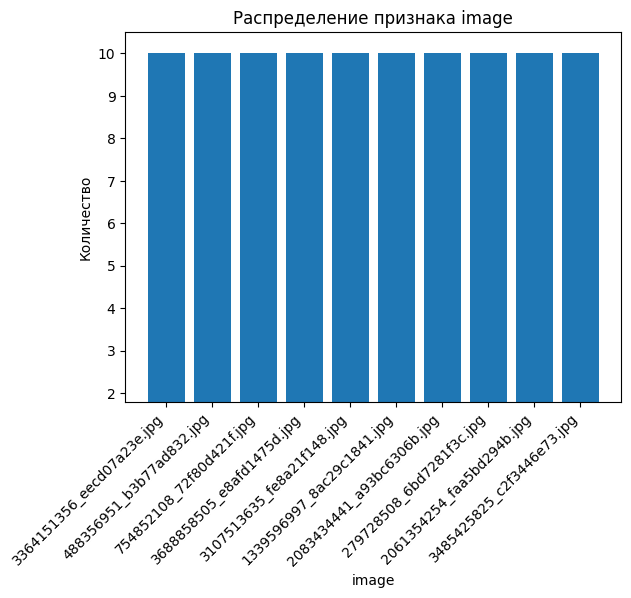

Смотрим статистику: query_id


count                            5822
unique                            977
top       2600867924_cd502fc911.jpg#2
freq                               34
Name: query_id, dtype: object

Лидеров и аутсайдеров: 


query_id
2600867924_cd502fc911.jpg#2    34
1554713437_61b64527dd.jpg#2    27
2522297487_57edf117f7.jpg#2    25
1536774449_e16b1b6382.jpg#2    25
3593392955_a4125087f6.jpg#2    22
                               ..
424779662_568f9606d0.jpg#2      1
430173345_86388d8822.jpg#2      1
2310126952_7dc86d88f6.jpg#2     1
363617160_6cb0c723be.jpg#2      1
2292406847_f366350600.jpg#2     1
Name: count, Length: 977, dtype: int64

Посмотрим на графике ТОП-10: 


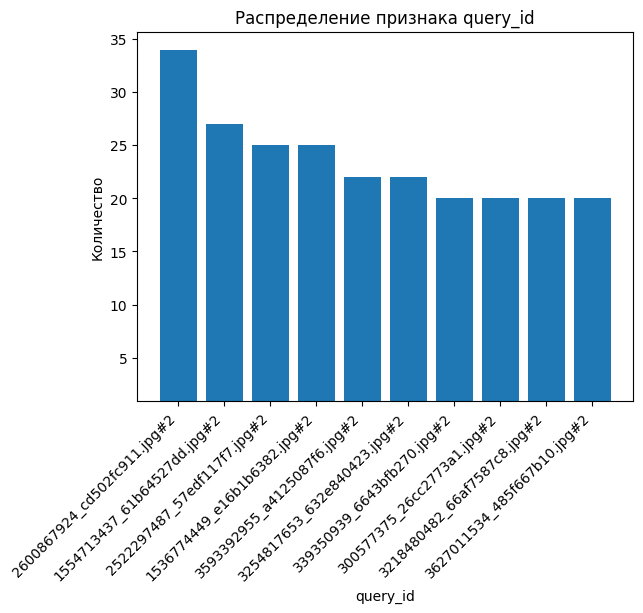

Смотрим статистику: query_text


count                                                  5822
unique                                                  977
top       Two dogs , one brown and white and one black a...
freq                                                     34
Name: query_text, dtype: object

Лидеров и аутсайдеров: 


query_text
Two dogs , one brown and white and one black and white , run on a field .                                   34
A grey dog walks on top of a fallen tree in the woods .                                                     27
a white woman in a green sweater holds a smiling child whilst a smiling boy in a yellow shirt looks on .    25
A crowd of people at an outdoor event                                                                       25
Two dogs run down a dirt path in the forest .                                                               22
                                                                                                            ..
Three women dressed in green celebrating St Patricks Day .                                                   1
A brown dog with a purple Frisbee in its mouth .                                                             1
A sled dog team running from the perspective of the rider .                                          

Посмотрим на графике ТОП-10: 


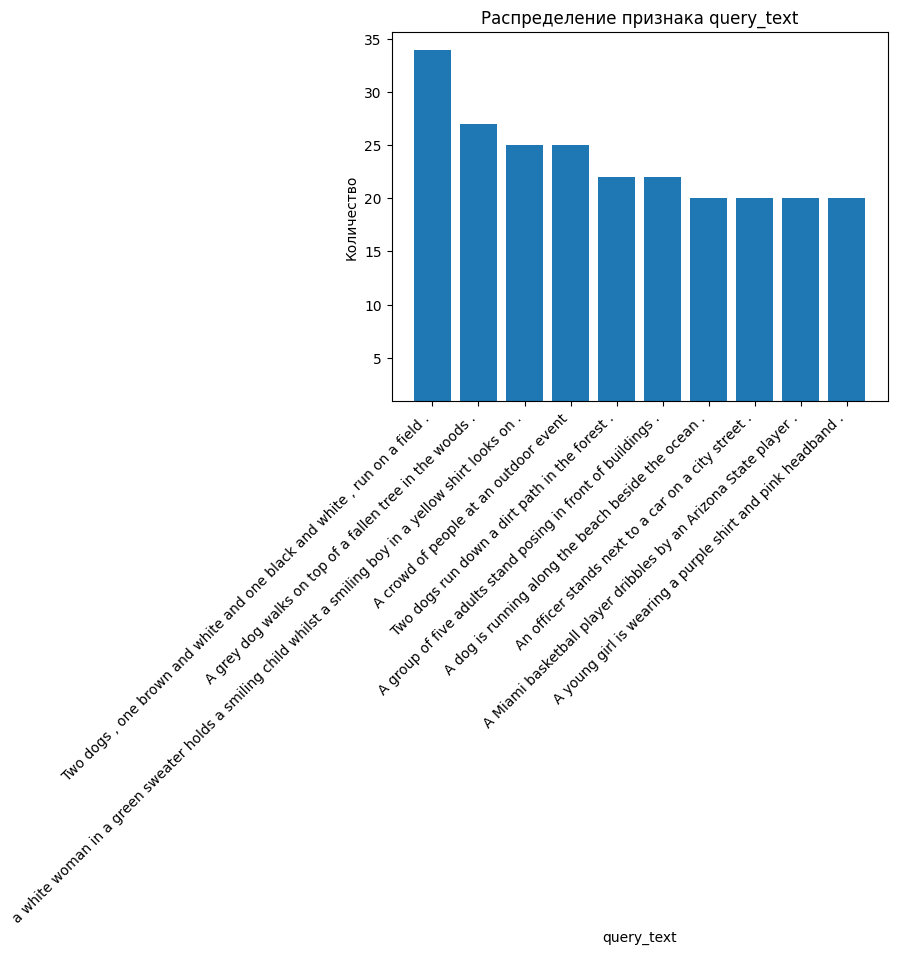

Смотрим статистику: query_id


count                             500
unique                            500
top       1177994172_10d143cb8d.jpg#0
freq                                1
Name: query_id, dtype: object

Лидеров и аутсайдеров: 


query_id
1177994172_10d143cb8d.jpg#0    1
1319634306_816f21677f.jpg#0    1
1177994172_10d143cb8d.jpg#2    1
1177994172_10d143cb8d.jpg#3    1
1177994172_10d143cb8d.jpg#4    1
                              ..
989851184_9ef368e520.jpg#2     1
989851184_9ef368e520.jpg#3     1
862156271_3eacea90a8.jpg#1     1
862156271_3eacea90a8.jpg#0     1
989851184_9ef368e520.jpg#4     1
Name: count, Length: 500, dtype: int64

Посмотрим на графике ТОП-10: 


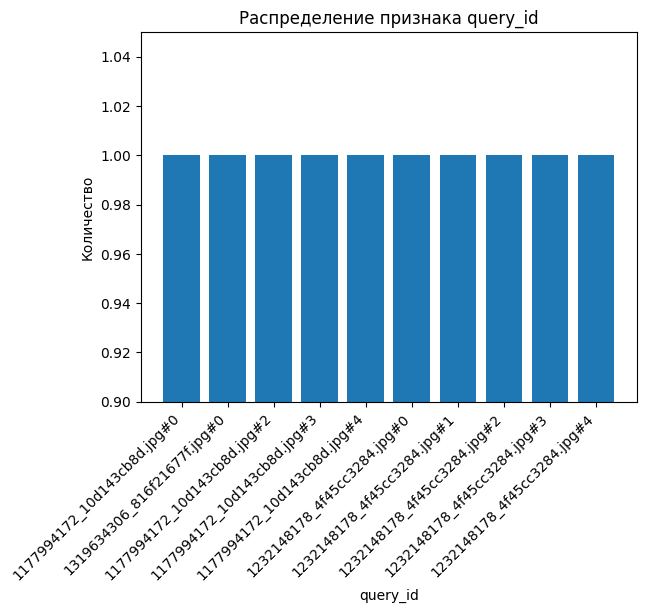

Смотрим статистику: query_text


count                                                   500
unique                                                  500
top       Two blonde boys , one in a camouflage shirt an...
freq                                                      1
Name: query_text, dtype: object

Лидеров и аутсайдеров: 


query_text
Two blonde boys , one in a camouflage shirt and the other in blue , are having a water fight .    1
A brown dog is sitting in some long grass .                                                       1
Two boys spraying each other with water                                                           1
Two children wearing jeans squirt water at each other .                                           1
Two young boys are squirting water at each other .                                                1
                                                                                                 ..
A black dog holding a weight in its mouth stands next to a person .                               1
A black dog holds a small white dumbbell in its mouth .                                           1
two girls walking in the street                                                                   1
Girls with orange hair standing on the street with some kind of bottle in their hand .   

Посмотрим на графике ТОП-10: 


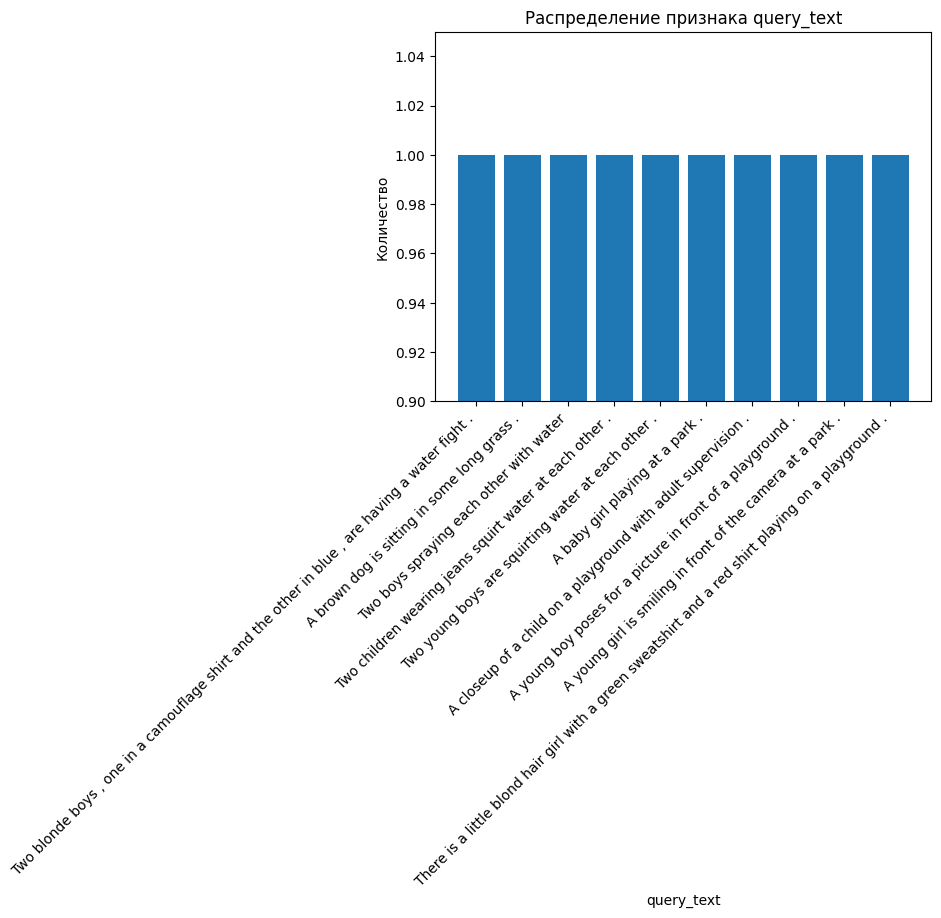

Смотрим статистику: image


count                           500
unique                          100
top       1177994172_10d143cb8d.jpg
freq                              5
Name: image, dtype: object

Лидеров и аутсайдеров: 


image
1177994172_10d143cb8d.jpg    5
2107838729_a527e434bd.jpg    5
123997871_6a9ca987b1.jpg     5
1319634306_816f21677f.jpg    5
1429546659_44cb09cbe2.jpg    5
                            ..
957682378_46c3b07bcd.jpg     5
973827791_467d83986e.jpg     5
989754491_7e53fb4586.jpg     5
3520936130_9e90872560.jpg    5
989851184_9ef368e520.jpg     5
Name: count, Length: 100, dtype: int64

Посмотрим на графике ТОП-10: 


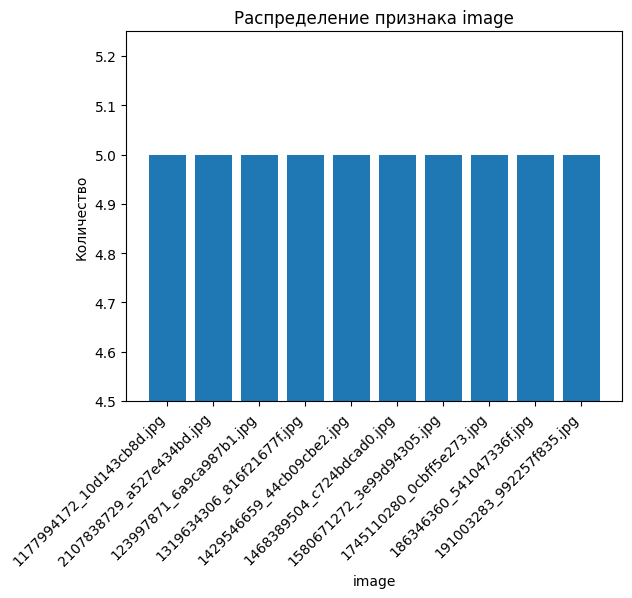

Смотрим статистику: image


count                         47830
unique                         1000
top       1572532018_64c030c974.jpg
freq                            120
Name: image, dtype: object

Лидеров и аутсайдеров: 


image
1572532018_64c030c974.jpg    120
3250695024_93e8ab7305.jpg    110
3224227640_31865b3651.jpg    100
191003285_edd8d0cf58.jpg     100
324208502_674488bcea.jpg     100
                            ... 
2295750198_6d152d7ceb.jpg     10
3578841731_f775cab089.jpg     10
363617160_6cb0c723be.jpg      10
3449114979_6cdc3e8da8.jpg     10
3567061016_62768dcce1.jpg     10
Name: count, Length: 1000, dtype: int64

Посмотрим на графике ТОП-10: 


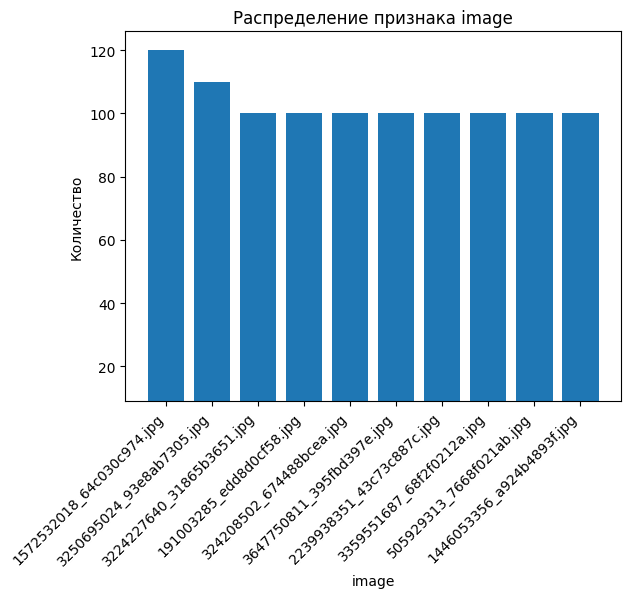

Смотрим статистику: query_id


count                          47830
unique                          1000
top       249394748_2e4acfbbb5.jpg#2
freq                             169
Name: query_id, dtype: object

Лидеров и аутсайдеров: 


query_id
249394748_2e4acfbbb5.jpg#2     169
820169182_f5e78d7d19.jpg#2     150
500446858_125702b296.jpg#2     149
2869491449_1041485a6b.jpg#2    143
327415627_6313d32a64.jpg#2     139
                              ... 
3191135894_2b4bdabb6d.jpg#2      9
3584561689_b6eb24dd70.jpg#2      7
3042380610_c5ea61eef8.jpg#2      7
1547883892_e29b3db42e.jpg#2      7
3197981073_3156963446.jpg#2      6
Name: count, Length: 1000, dtype: int64

Посмотрим на графике ТОП-10: 


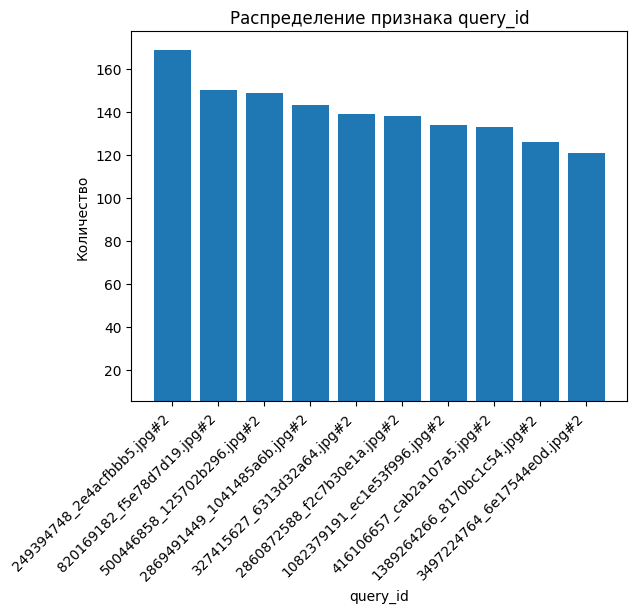

Смотрим статистику: fraction


count    47830.000000
mean         0.068786
std          0.207532
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: fraction, dtype: float64

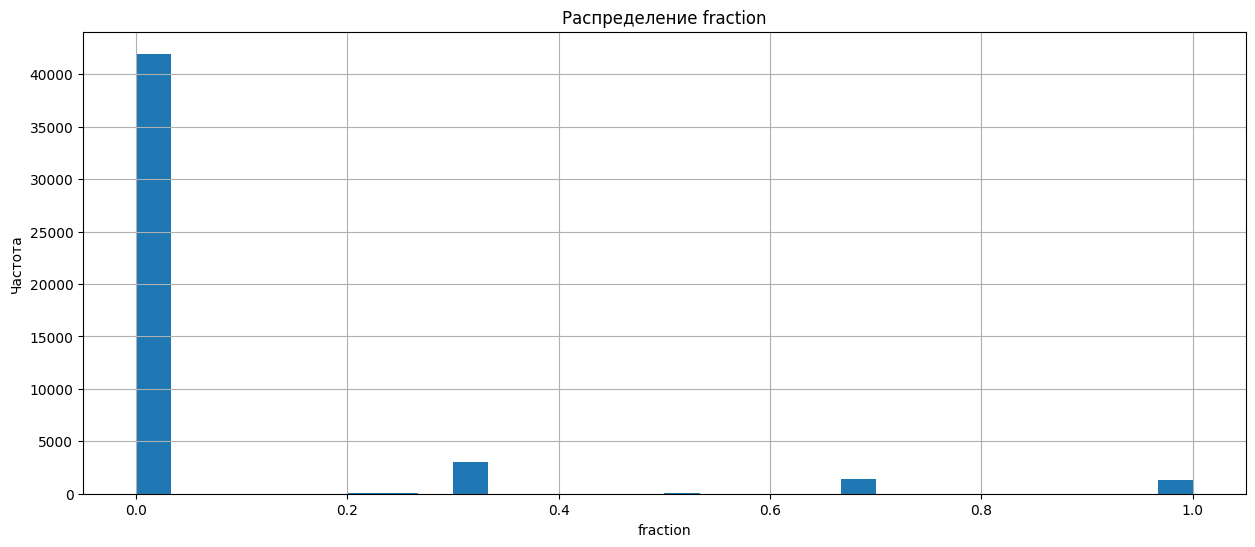

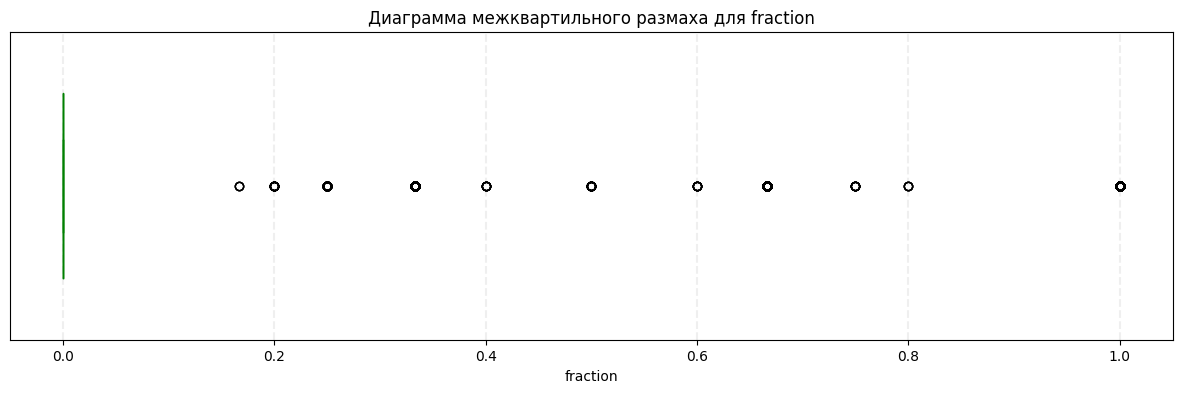


 fraction находится в диапазоне от 0.00 до 1.00, посмотрим как распределяются данные, видим на графике выше:
75% объектов находятся в диапазоне до 0.0 
 
 Всего значений отличных от 0: 5860.0. 
 1Q = 0.0, 
 3Q = 0.0, 
 Межквартильный размах = 0.0,
Смотрим статистику: conf_cnt


count    47830.000000
mean         0.208488
std          0.628898
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          5.000000
Name: conf_cnt, dtype: float64

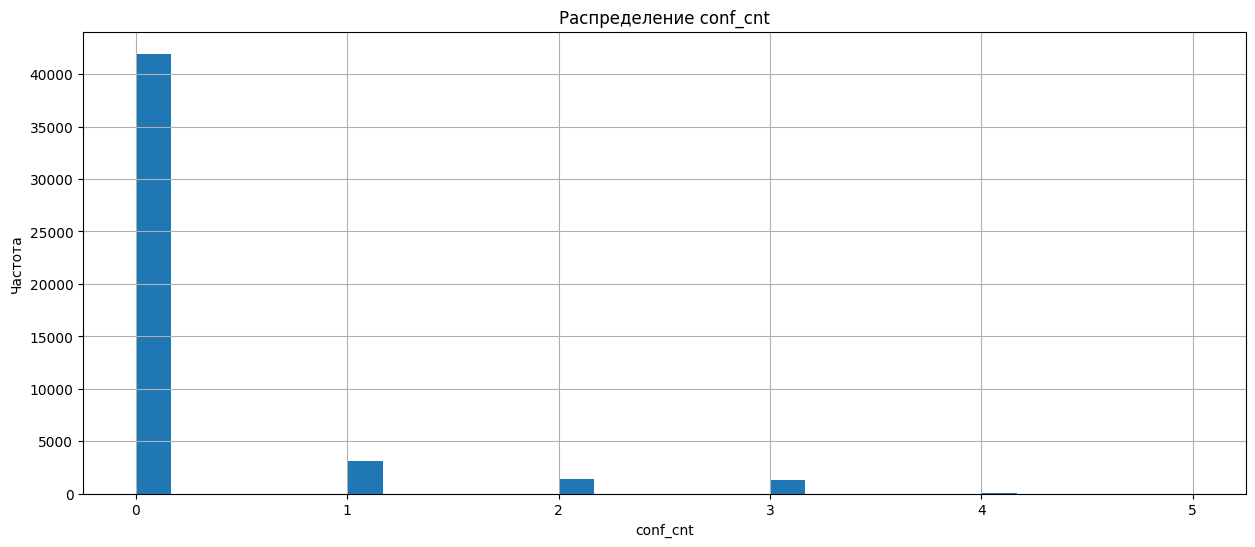

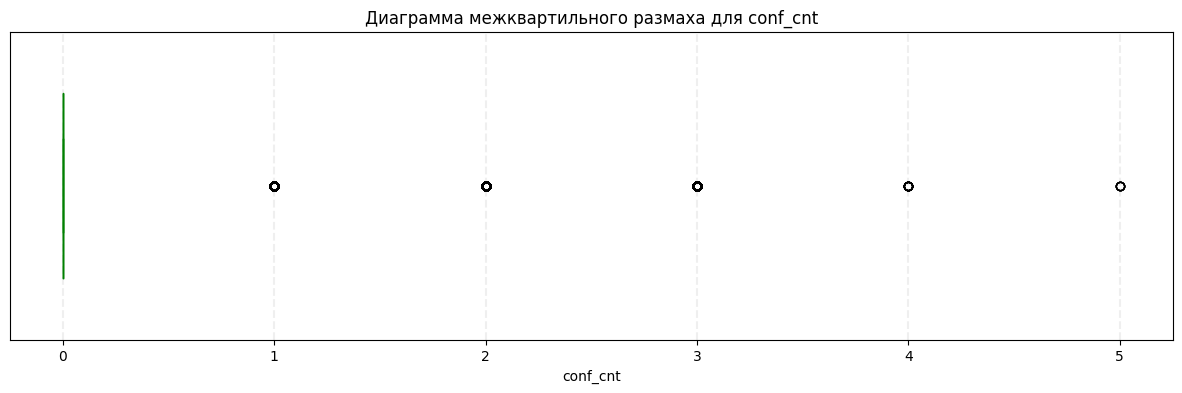


 conf_cnt находится в диапазоне от 0.00 до 5.00, посмотрим как распределяются данные, видим на графике выше:
75% объектов находятся в диапазоне до 0.0 
 
 Всего значений отличных от 0: 5860.0. 
 1Q = 0.0, 
 3Q = 0.0, 
 Межквартильный размах = 0.0,
Смотрим статистику: not_conf_cnt


count    47830.000000
mean         2.820155
std          0.656676
min          0.000000
25%          3.000000
50%          3.000000
75%          3.000000
max          6.000000
Name: not_conf_cnt, dtype: float64

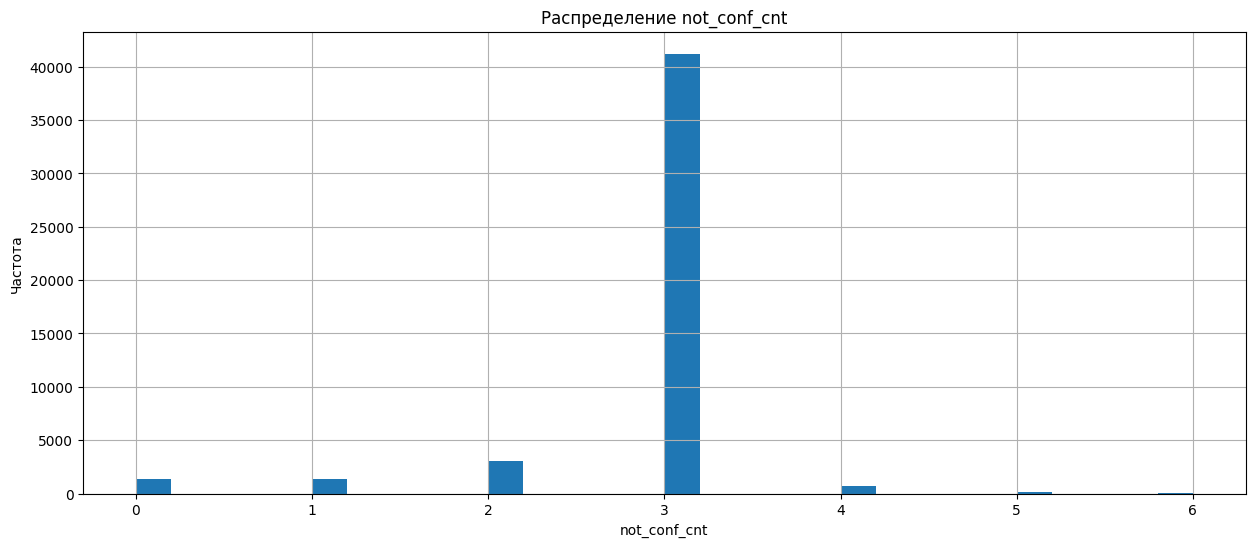

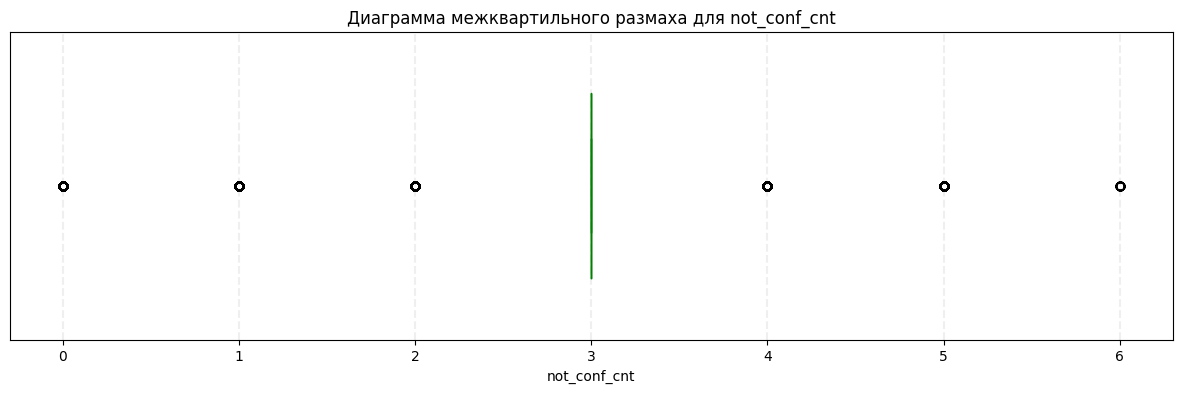


 not_conf_cnt находится в диапазоне от 0.00 до 6.00, посмотрим как распределяются данные, видим на графике выше:
75% объектов находятся в диапазоне до 3.0 
 
 Всего значений отличных от 0: 46507.0. 
 1Q = 3.0, 
 3Q = 3.0, 
 Межквартильный размах = 0.0,
Смотрим статистику: image


count                          5822
unique                         1000
top       3107513635_fe8a21f148.jpg
freq                             10
Name: image, dtype: object

Лидеров и аутсайдеров: 


image
3107513635_fe8a21f148.jpg    10
3364151356_eecd07a23e.jpg    10
279728508_6bd7281f3c.jpg     10
754852108_72f80d421f.jpg     10
488356951_b3b77ad832.jpg     10
                             ..
3227148358_f152303584.jpg     2
2914206497_5e36ac6324.jpg     2
2533424347_cf2f84872b.jpg     2
3591462960_86045906bd.jpg     2
241346971_c100650320.jpg      2
Name: count, Length: 1000, dtype: int64

Посмотрим на графике ТОП-10: 


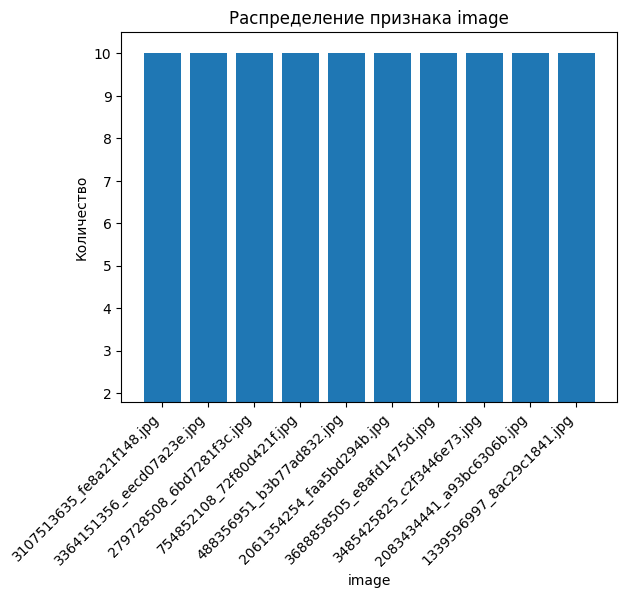

Смотрим статистику: query_id


count                            5822
unique                            977
top       2600867924_cd502fc911.jpg#2
freq                               34
Name: query_id, dtype: object

Лидеров и аутсайдеров: 


query_id
2600867924_cd502fc911.jpg#2    34
1554713437_61b64527dd.jpg#2    27
2522297487_57edf117f7.jpg#2    25
1536774449_e16b1b6382.jpg#2    25
3593392955_a4125087f6.jpg#2    22
                               ..
424779662_568f9606d0.jpg#2      1
430173345_86388d8822.jpg#2      1
2310126952_7dc86d88f6.jpg#2     1
363617160_6cb0c723be.jpg#2      1
2292406847_f366350600.jpg#2     1
Name: count, Length: 977, dtype: int64

Посмотрим на графике ТОП-10: 


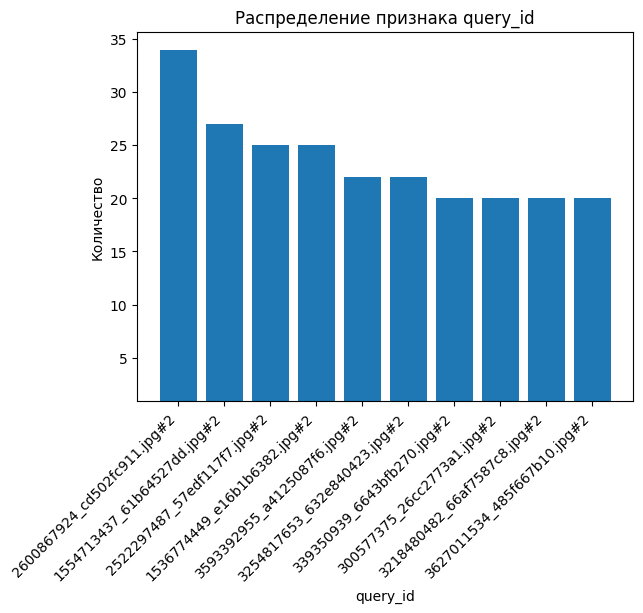

Смотрим статистику: exp_1


count    5822.000000
mean        1.436620
std         0.787084
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: exp_1, dtype: float64

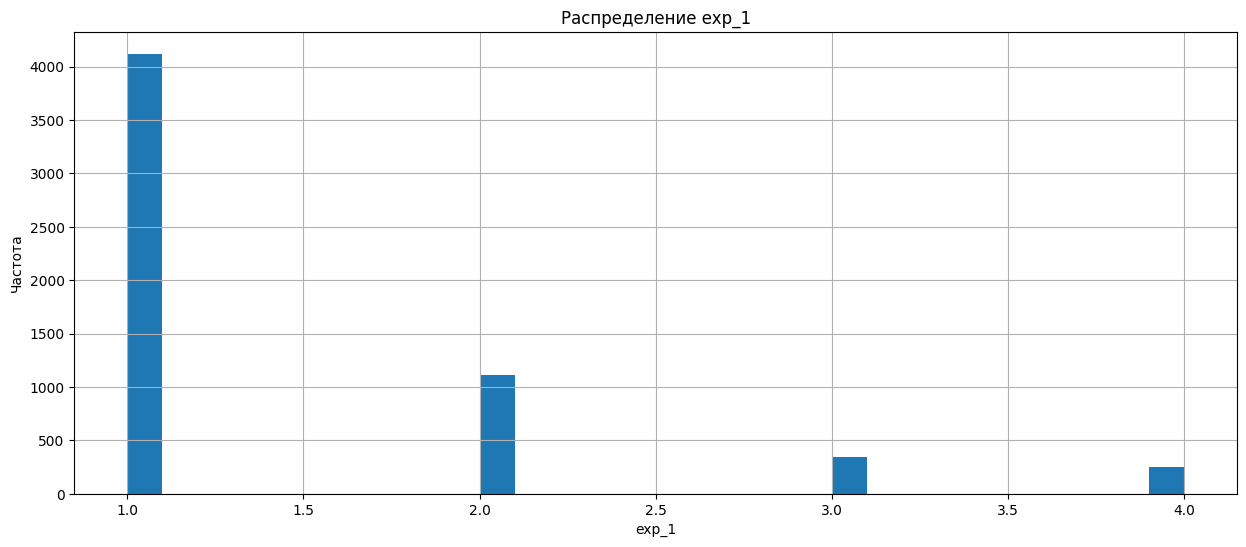

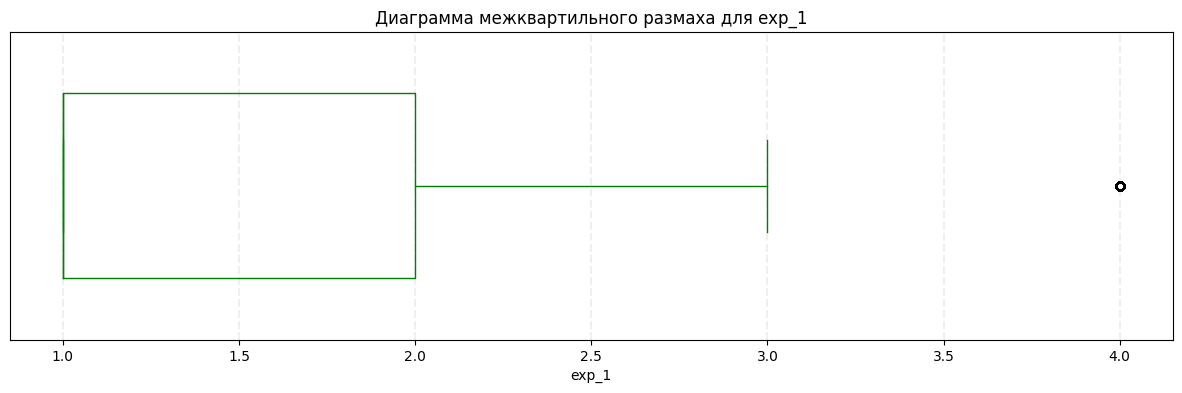


 exp_1 находится в диапазоне от 1.00 до 4.00, посмотрим как распределяются данные, видим на графике выше:
75% объектов находятся в диапазоне до 2.0 
 
 Всего значений отличных от 0: 5822.0. 
 1Q = 1.0, 
 3Q = 2.0, 
 Межквартильный размах = 1.0,
Смотрим статистику: exp_2


count    5822.000000
mean        1.624356
std         0.856222
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: exp_2, dtype: float64

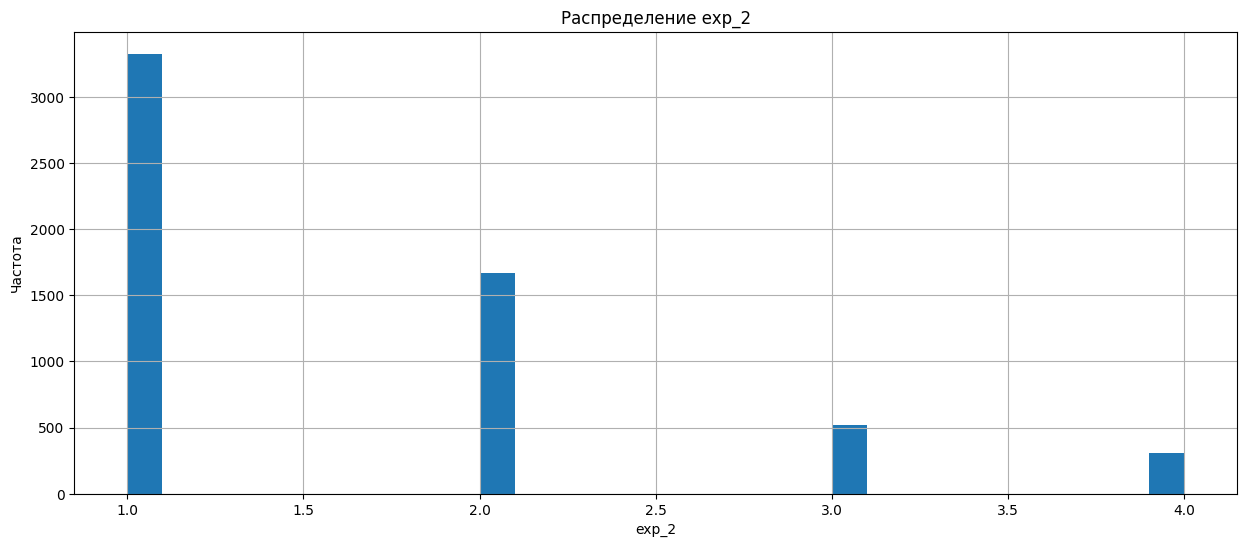

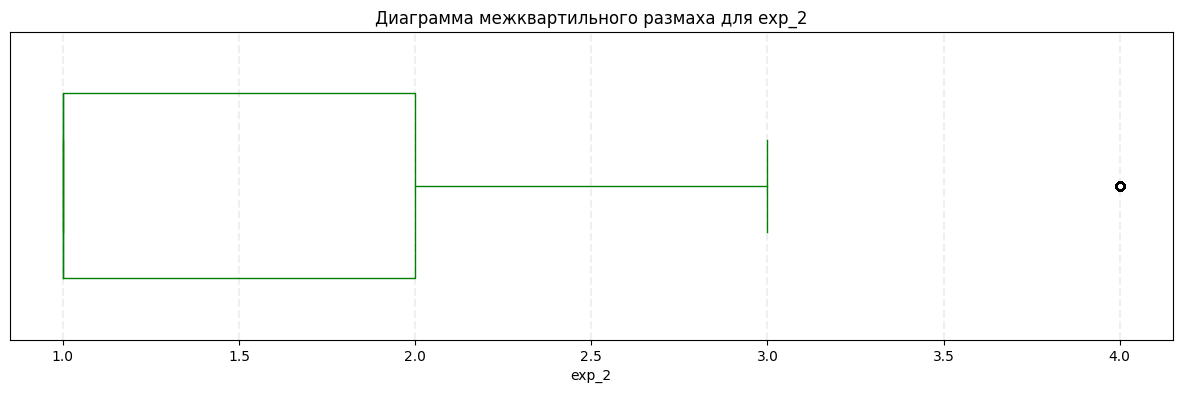


 exp_2 находится в диапазоне от 1.00 до 4.00, посмотрим как распределяются данные, видим на графике выше:
75% объектов находятся в диапазоне до 2.0 
 
 Всего значений отличных от 0: 5822.0. 
 1Q = 1.0, 
 3Q = 2.0, 
 Межквартильный размах = 1.0,
Смотрим статистику: exp_3


count    5822.000000
mean        1.881999
std         0.904087
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         4.000000
Name: exp_3, dtype: float64

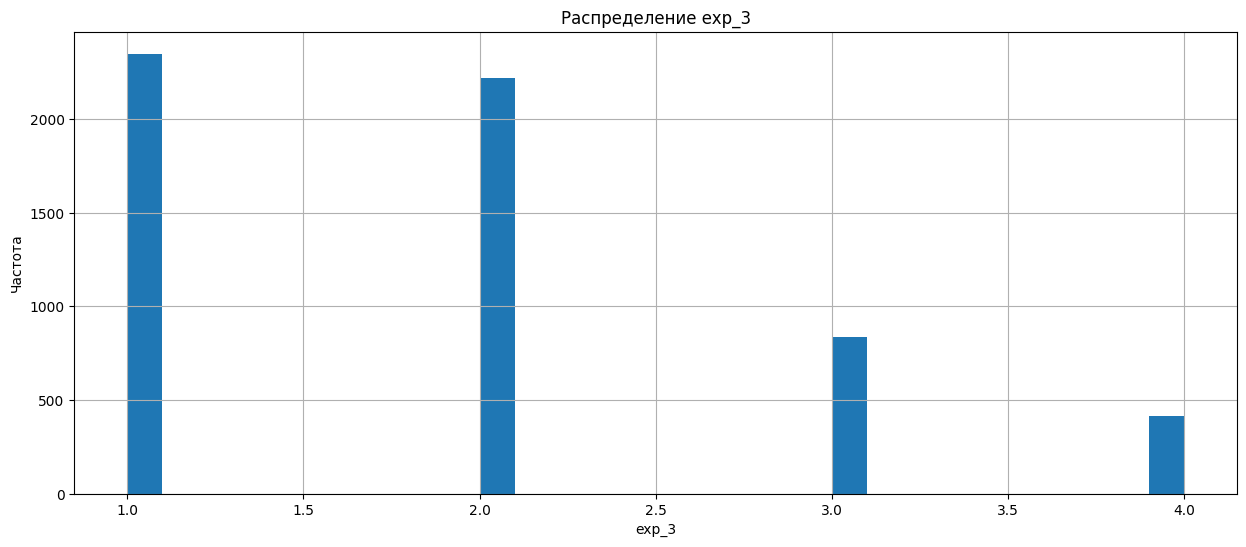

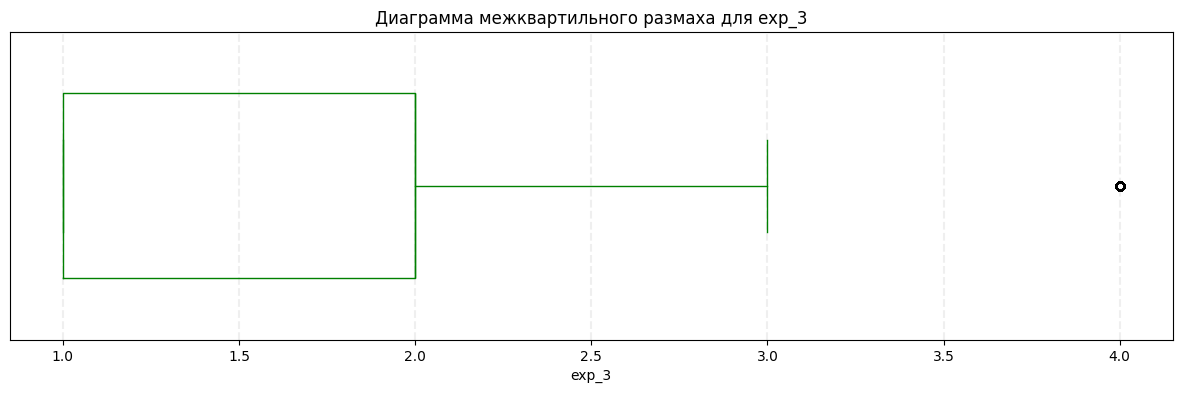


 exp_3 находится в диапазоне от 1.00 до 4.00, посмотрим как распределяются данные, видим на графике выше:
75% объектов находятся в диапазоне до 2.0 
 
 Всего значений отличных от 0: 5822.0. 
 1Q = 1.0, 
 3Q = 2.0, 
 Межквартильный размах = 1.0,


In [13]:
for i in table:
    numeric_columns = i.select_dtypes(include='number').columns
    text_columns = i.select_dtypes(include='object').columns
    for j in i.columns:
        if j in numeric_columns:
            e_d_a(j, j, i)
        if j in text_columns:
            e_d_a_categorical(j, j, i)

## Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [14]:

def lemma_clear(text):
    lemm = nlp(text)
    lemm = " ".join([token.lemma_ for token in lemm])


    return " ".join(lemm.split())

In [15]:
# spacy.cli.download("en_core_web_sm")

In [16]:
nlp = spacy.load("en_core_web_sm")


child_dict = ['child', 'baby', 'boy', 'girl', 'teenager', 'schoolboy', 'youth', 'newborn']

corpus = train_df['query_text'].apply(lemma_clear)

In [17]:
def is_ban_word(text):
    for s in child_dict: 
        if text.find(s) > -1:
            return False
    return True

train_df['lem_query_text'] = corpus
train_df['is_in_law'] = corpus.apply(is_ban_word)

In [18]:
def spl(text):
    return text[:text.find('#')]

In [19]:
child_images = list(train_df[train_df['is_in_law']==False]['query_id'].apply(spl).unique())

In [20]:
print(len(child_images))
print(len(train_df))

277
5822


In [21]:
def is_not_forb(text):
    if text in child_images:
        return False
    else:
        return True
    
train_df_clear = train_df[train_df['is_in_law']]
train_df = train_df_clear[train_df_clear['image'].apply(is_not_forb)]

In [22]:
print(len(train_df))

3271


## Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [23]:
# train_dataset['lem_query_text'] = corpus
# train_dataset['is_in_law'] = corpus.apply(is_ban_word)

In [24]:
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
tqdm.pandas()

# if torch.backends.mps.is_available():
#     device = torch.device('mps')
# else:
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# инициализация токенизатор, конфигурацию и модель BERT
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model_emb_txt = transformers.BertModel.from_pretrained('bert-base-uncased', config=config).to(device)


tokenized = train_df['query_text'].progress_apply(lambda x:
                                           tokenizer.encode(x, max_length=512,
                                                            truncation=True, add_special_tokens=True))

padded = pad_sequence([torch.as_tensor(seq) for seq in tokenized], batch_first=True)

attention_mask = padded > 0
attention_mask = attention_mask.type(torch.LongTensor).to(device)

100%|████████████████████████████████████████████████████████████████████████████| 3271/3271 [00:02<00:00, 1513.50it/s]


In [26]:
len(train_df['query_text'])

3271

In [27]:
# corpus = train_df['lem_query_text']
# corpus = test_queries['query_text'].apply(lemma_clear)
# count_tf_idf = TfidfVectorizer(stop_words=list(stopwords)) 

# tf_idf_train = count_tf_idf.fit_transform(corpus) 



In [28]:
# print("Размер матрицы:", tf_idf_train.shape)

In [29]:
padded.shape[0]

3271

In [30]:
batch_size = 100
embeddings = []

for i in tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size * i:batch_size * (i + 1)]).to(device)
    attention_mask_batch = torch.Tensor(attention_mask[batch_size * i:batch_size * (i + 1)]).to(device)

    with torch.no_grad():
        batch_embeddings = model_emb_txt(batch, attention_mask=attention_mask_batch)

    embeddings.append(batch_embeddings[0][:, 0, :].cpu().numpy())

# Обработка остатка
if padded.shape[0] % batch_size != 0:
    last_batch = torch.LongTensor(padded[(padded.shape[0] // batch_size) * batch_size:]).to(device)
    attention_mask_last_batch = torch.Tensor(attention_mask[(padded.shape[0] // batch_size) * batch_size:]).to(device)

    with torch.no_grad():
        last_batch_embeddings = model_emb_txt(last_batch, attention_mask=attention_mask_last_batch)

    embeddings.append(last_batch_embeddings[0][:, 0, :].cpu().numpy())

text_features = np.concatenate(embeddings)

# # сохранение эмбеддингов в файл
# np.save(os.path.join(BASE_PATH, 'text_features.npy'), text_features)

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 12.96it/s]


In [31]:
len(text_features)

3271

In [32]:
# text_features = np.load(os.path.join(BASE_PATH, 'text_features.npy'))

# дополнение датасета эмбедингами
train_df['text_embeddings'] = text_features.tolist()

C:\Users\fd\AppData\Local\Temp\ipykernel_11896\872721027.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text_embeddings'] = text_features.tolist()


## Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [33]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
weights = ResNet18_Weights.DEFAULT
resnet = resnet18(weights=weights).to(device)

for param in resnet.parameters():
    param.requires_grad_(False) 

# оставим только свёрточные слои
modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules).to(device)

resnet.eval() 



preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_images_list = train_df['image'].unique()

In [35]:
vektors = []

for image_name in tqdm(train_images_list):
    image = Image.open(os.path.join(TRAIN_IMAGES, image_name)).convert('RGB')
    image = preprocess(image)
    image = Variable(image.unsqueeze(0)).to(device)

    vektor = resnet(image).cpu().flatten().numpy()
    vektors.append(vektor)


100%|████████████████████████████████████████████████████████████████████████████████| 717/717 [00:14<00:00, 49.92it/s]


In [36]:
images_vektors = np.array(vektors)
data = pd.DataFrame({'image': train_images_list, 'image_vector': images_vektors.tolist()})

train = train_df.merge(data, on='image', how='left')

## Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [37]:
train.head(2)

,image,query_id,query_text,lem_query_text,is_in_law,text_embeddings,image_vector
0,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,a man sleep under a blanket on a city street .,True,"[0.22594551742076874, -0.14776965975761414, -0...","[0.6939702033996582, 3.030940055847168, 2.9169..."
1,3187395715_f2940c2b72.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,a man sleep under a blanket on a city street .,True,"[0.22594551742076874, -0.14776965975761414, -0...","[0.27172765135765076, 2.481905460357666, 1.619..."


In [38]:
for i in range(2):
    print(f'''
    Размерность {i+1}-й пары:
    text_embeddings: {len(train.iloc[i][-2])}
    image_vector: {len(train.iloc[i][-1])}
    ''')


    Размерность 1-й пары:
    text_embeddings: 768
    image_vector: 512
    

    Размерность 2-й пары:
    text_embeddings: 768
    image_vector: 512
    


C:\Users\fd\AppData\Local\Temp\ipykernel_11896\349670188.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text_embeddings: {len(train.iloc[i][-2])}
C:\Users\fd\AppData\Local\Temp\ipykernel_11896\349670188.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_vector: {len(train.iloc[i][-1])}


In [39]:
train['concatenated_vector'] = train.apply(lambda row: np.concatenate([row['text_embeddings'],
                                                                             row['image_vector']], axis=None), axis=1)
print(f'Размерность объединенного вертора: {len(train.iloc[0][-1])}')

Размерность объединенного вертора: 1280


C:\Users\fd\AppData\Local\Temp\ipykernel_11896\3789996830.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Размерность объединенного вертора: {len(train.iloc[0][-1])}')


In [40]:
train.head(2)

,image,query_id,query_text,lem_query_text,is_in_law,text_embeddings,image_vector,concatenated_vector
0,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,a man sleep under a blanket on a city street .,True,"[0.22594551742076874, -0.14776965975761414, -0...","[0.6939702033996582, 3.030940055847168, 2.9169...","[0.22594551742076874, -0.14776965975761414, -0..."
1,3187395715_f2940c2b72.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,a man sleep under a blanket on a city street .,True,"[0.22594551742076874, -0.14776965975761414, -0...","[0.27172765135765076, 2.481905460357666, 1.619...","[0.22594551742076874, -0.14776965975761414, -0..."


In [41]:
def mean_exp(x):
    return np.mean([x['exp_1'], x['exp_2'], x['exp_3']])

expert_annotat['mean_exp'] = expert_annotat.apply(mean_exp, axis=1)

final_df = train.merge(expert_annotat, on=['image', 'query_id'], how='inner')[['image', 'concatenated_vector', 'mean_exp']]
# перевод экспертные оценки из шкалы 1-4 в шкалу 0-1.
scaler = MinMaxScaler()
final_df['mean_exp'] = scaler.fit_transform(final_df[['mean_exp']])

## Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [42]:
def rmse_score(values, predict):
    return sqrt(mean_squared_error(values, predict))

rmse_scorer = make_scorer(rmse_score)

# функция для вывода результатов
def output_results(trial):
    print('Результаты подборы параметров:')
    print('  RMSE:', round(trial.value, 3))
    print('  Params: ')
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))


In [43]:
gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=RS)
train_indices, test_indices = next(gss.split(X=final_df.drop(columns=['mean_exp']), y=final_df['mean_exp'], 
                                             groups=final_df['image']))
train_df, valid_df = final_df.loc[train_indices], final_df.loc[test_indices]

X_train = train_df['concatenated_vector'].apply(pd.Series).values
y_train = train_df['mean_exp']

X_valid = valid_df['concatenated_vector'].apply(pd.Series).values
y_valid = valid_df['mean_exp']

In [44]:
model = LinearRegression()
model.fit(X_train, y_train)

# прогнозирование на тестовых данных
y_pred = model.predict(X_valid)

# оценка модели
print(f'RMSE: {rmse_score(y_valid, y_pred)}')

RMSE: 0.5787040165541167


## Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [45]:
test_images_list = test_df['image'].unique()

test_vektors = []

for image_name in tqdm(test_images_list):
    image = Image.open(os.path.join(TEST_IMAGES, image_name)).convert('RGB')
    image = preprocess(image)
    image = Variable(image.unsqueeze(0)).to(device)

    vektor = resnet(image).cpu().flatten().numpy() # преобразование в одномерный массив
    test_vektors.append(vektor)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.99it/s]


In [46]:
images_test_vektors = np.array(test_vektors)
test = pd.DataFrame({'image': test_images_list, 'image_vector': images_test_vektors.tolist()})

In [47]:
lemmatizer = WordNetLemmatizer()
best_regressor = model
def lemmatize_text(text):
    return ' '.join(lemmatizer.lemmatize(word, pos=penn2morphy(tag)) for word, tag in pos_tag(word_tokenize(text)))

def penn2morphy(penntag):
    morphy_tag = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 

def clean_tokenize_text(text):
    text = clean_text(text)
    text = stopwords_tokenize(text)
    text = lemmatize_text(text)
    return text.split()


def clean_text(txt):
    txt = txt.lower() 
    txt = re.sub(LETTERS, ' ', txt) 
    txt = re.sub(SPACES, r'\1', txt)
    return txt

def stopwords_tokenize(x):
    tokens = word_tokenize(x)
    tokenization = [word for word in tokens if not word in english_stopwords]
    return ' '.join(tokenization)

def get_text_embedding(input_text):

    tokenized = tokenizer.encode(input_text, max_length=512, truncation=True, add_special_tokens=True)
    padded = pad_sequence([torch.as_tensor(tokenized)], batch_first=True)

    attention_mask = padded > 0
    attention_mask = attention_mask.type(torch.LongTensor).to(device)

    with torch.no_grad():
        text_embedding = model_emb_txt(padded.to(device), attention_mask=attention_mask)[0][:, 0, :].cpu().numpy()
    return text_embedding[0].tolist()

# функция тестирования
def imag_test(query_text):
    
    text_embedding = get_text_embedding(query_text)
    test['vector'] = test['image_vector'].apply(lambda x: text_embedding+x)

    test['vector'] = test['vector'].apply(lambda x: np.array(x, dtype=np.float32))

    test_vectors = np.stack(test['vector'].to_numpy())
    X_test_tensor = torch.tensor(test_vectors, dtype=torch.float32)

    test['pred'] = best_regressor.predict(X_test_tensor)
    
    max_skore = test['pred'].max() # 
    path = test[test['pred'] == test['pred'].max()]['image'].values[0]
    return max_skore, path

# функция для вывода изображения по запросу
def display_image_with_caption(query_text):
    text = clean_tokenize_text(query_text)
    if any(i in text for i in child_dict):
        print(query_text)
        print('Изображение не доступно в доступно в данном регионе')
    else:
        max_skore, image_path = imag_test(text)
        fig, ax = plt.subplots(figsize=(6, 6))
        image_path = os.path.join(TEST_IMAGES, image_path)
        img = Image.open(image_path)
        ax.imshow(img)
        ax.set_title(query_text, fontsize=12)
        ax.axis('off')
        plt.show()
        print(f'Мера соответствия изображения составляет: {max_skore}')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


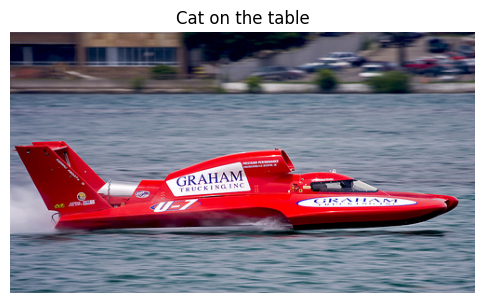

Мера соответствия изображения составляет: 2.2095741638071393


In [48]:
# from nltk.corpus import stopwords
# nltk.download('stopwords')

english_stopwords = stopwords.words('english')

display_image_with_caption('Cat on the table')

<div class="alert alert-info">
<font size="4", color = "brown"><b>✍ Комментарий студента v0</b></font>
    <br /> 
    <font size="3", color = "brown">
<br /> Здесь какая то засада. Если импорт стоит только вначале ноутбука (from nltk.corpus import stopwords
nltk.download('stopwords')), то здесь вылетает ошибка... 

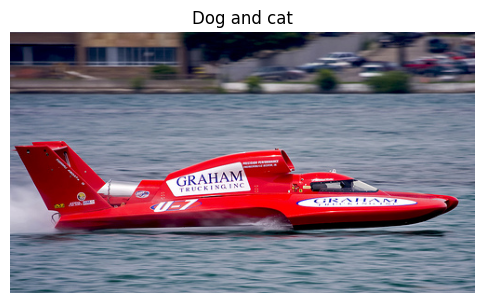

Мера соответствия изображения составляет: 2.668089612837816


In [49]:
display_image_with_caption('Dog and cat')

In [50]:
display_image_with_caption('a child on a swing')

a child on a swing
Изображение не доступно в доступно в данном регионе


## Выводы

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Проверены экспертные оценки и краудсорсинговые оценки
- [x]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [x]  Изображения векторизованы
- [x]  Текстовые запросы векторизованы
- [x]  Данные корректно разбиты на тренировочную и тестовую выборки
- [x]  Предложена метрика качества работы модели
- [x]  Предложена модель схожести изображений и текстового запроса
- [x]  Модель обучена
- [x]  По итогам обучения модели сделаны выводы
- [x]  Проведено тестирование работы модели
- [x]  По итогам тестирования визуально сравнили качество поиска

Код работает, детей фильтрует, а вот качество страдает. Нужно подобрать модель которая лучше будет работать с изображениями.